# **Project: Plant Seedlings Classification**



### **Context:**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.




### **Objective:**

The aim of this project is to **use a deep learning model to classify plant seedlings through supervised learning.**


### **Data Description:**
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species at several growth stages.**

You are provided with a dataset of images of plant seedlings at various stages of growth.

- Each image has a filename that is its unique id.
- The dataset comprises of 12 plant species.
- The goal of the project is to create a classifier capable of determining a plant's species from a photo.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet


### **Dataset:**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- The original files are from Kaggle. Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- Kaggle project link: https://www.kaggle.com/c/plant-seedlings-classification/data?select=train

**Note: Download the dataset provided on Olympus**



### **Learning Outcomes:**
- Pre-processing of image data
- Visualization of images
- Building the CNN
- Evaluating the Model


### **Note:**


We are covering some additional concepts for the case study(Masking, HSV Conversion, Data Augmentation etc.)


## **Importing the necessary libraries**

In [1]:
import os
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools
import seaborn as sns
import numpy as np


import tensorflow as tf
from tensorflow.keras.models import Sequential,Model #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D #importing different layers 
from tensorflow.keras.layers import BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# GLOBAL VARIABLES

seed = 7

## **Reading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
os.chdir('/content/gdrive')

In [4]:
# Load the image file of dataset
images = np.load('MyDrive/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('MyDrive/Labels.csv')

## **Overview of the dataset**


Let's print the shape of the images and labels 

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB  images of shape 128 x 128 each. As mentioned, each image is an RGB image having 3 channels 

Let's plot the first 8 images 

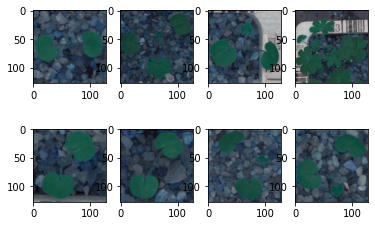

In [6]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])

Let's understand if the dataset is imbalanced or not 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

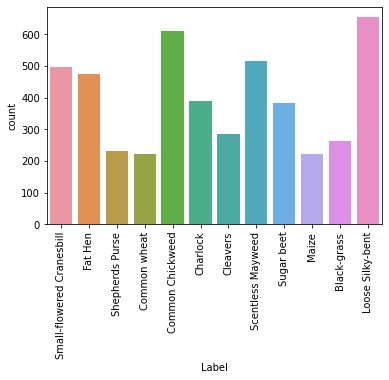

In [7]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

As you can see from the above plot, the dataset is quite balanced. But, we might need to stratify the train_test_split.

## **Exploratory Data Analysis** 

### **Plotting mean images** 

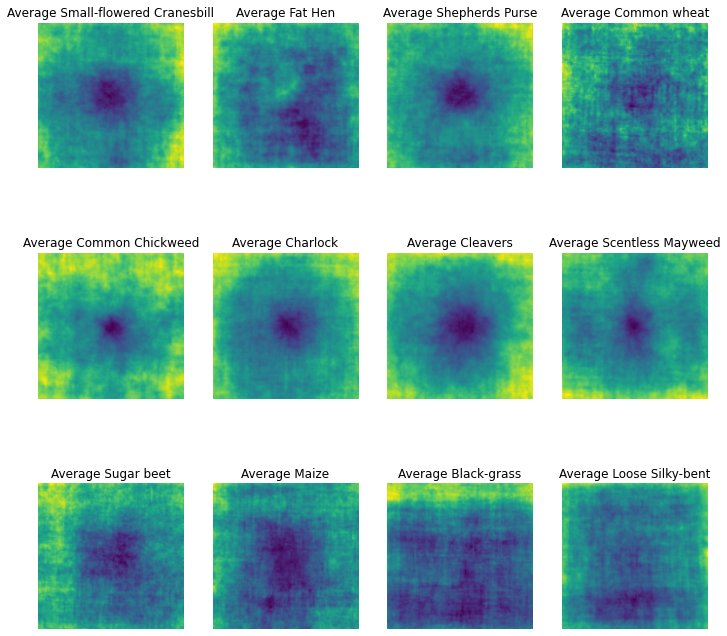

In [8]:
def find_mean_img(full_mat):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((150,150))
  
    return mean_img

CATEGORIES=labels['Label'].unique()
d={ i:[] for i in CATEGORIES}

for i in labels.index:
  gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
  gray = cv2.resize(gray,(150,150))
  d[labels['Label'][i]].append(gray)

l=[]
for i in d.keys():
  l.append(find_mean_img(d[i]))

plt.subplots(figsize=(12,12))
for i in range(len(l)):
    plt.subplot(3,4,i + 1,title='Average '+list(d.keys())[i])
    plt.imshow(l[i])
    plt.axis('off')




* From the above plots, we can say that small-flowered cranesbill, Shepherds Purse, Charlock, and Cleavers have similar kinds of shapes like width and length of the leaves. They mostly have smaller lengths and widths.
* From the Average Fat Hen graph, we can observe that the length of the leaf is large and the width of the leaf is small.
* Common Wheat, Silky bent, and Blackgrass possess a similar kind of structure, their width is narrower and the length of the leaf is longer as compared to others. It's a kind of grass, not a leaf.
* Mayweed and Common Chickweed have a similar kind of structure, Their leaves have smaller lengths and widths comparing to the Charlock category.
* Sugar beet and Maize have a similar structure where the length of the leaves is more but the width is less.


## **Data Preprocessing: Image Preprocessing**

## **Applying image processing**

It is a very important step to perform image preprocessing. Preprocessing an image is an intensive task. We will be performing the following steps in order to process the images

**Convert the RGB images into HSV**

**The HSV model** describes colors similarly to how the human eye tends to perceive color. RGB defines color in terms of a combination of primary colors. In situations where color description plays an integral role, the HSV color model is often preferred over the RGB model.

**'Hue'** represents the color, **'Saturation'** represents the amount to which that respective color is mixed with white and **'Value'** represents the amount to which that respective color is mixed with black (Gray level).

**HSV color space** is more often used in computer vision owing to its **superior performance** compared to RGB color space in varying illumination levels. Often thresholding and masking is done in HSV color space. So it is very important to know the HSV values of the color we want to filter out.

In RGB, we cannot separate color information from luminance. HSV or Hue Saturation Value is used to separate image luminance from color information.

**In this problem, color is an important factor** in identifying the plant species. Hence converting BGR TO HSV is a good idea.

**In order to remove the noise, we will have to blur the images (Gaussian Blurring)** 

**In order to remove the background, we will have to create a mask.**

Creating a mask will remove the noise. We have then applied some [morphological transformation](https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html) (closing=Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.) to remove the imperfections from the image.

**Visualize data after pre-processing.**


**Normalizing the images**





**Note:** OpenCV reads in images in the BGR format (instead of RGB) because when OpenCV was first being developed, the BGR color format was popular among camera manufacturers and image software providers. The red channel was considered one of the least important color channels, so was listed last, and many bitmaps use the BGR format for image storage. However, now the standard has changed and most image software and cameras use the RGB format, which is why, in programs, it's good practice to initially convert BGR images to RGB before analyzing or manipulating any images.

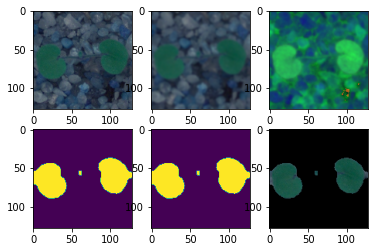

# CLEANED IMAGES


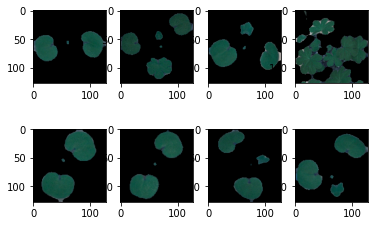

In [9]:
new_train = []
sets = []; getEx = True
for i in images:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) #Using BGR TO HSV conversion. reason is mentioned above
    #HSV Bou daries for the Green color (GREEN PARAMETERS)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper) # create a mask 
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) #getting structring element ( kernal) of sie 11x11
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) # applying morphological transformation ( closing operation ) to remove imperfections from the binary image ( mask)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)
print("# CLEANED IMAGES")
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Normalizing the dataset

In [10]:
# Normalize image data.
new_train = new_train / 255

## **Making the data compatible**

- Convert labels from digits to one hot vectors.
- Check the shape of the data. Reshape the data into shapes compatible with Keras models, if not already compatible.


In [11]:
# Convert labels from digits to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(labels)

In [12]:
print(y.shape)
print(new_train.shape)

(4750, 12)
(4750, 128, 128, 3)


## **Splitting the dataset**

In this step, we are going to split the training dataset for validation. We are using the train_test_split() function from scikit-learn. Here we are splitting the dataset keeping the test_size=0.1. It means 10% of total data is used as testing data and the other 90% as training data. Check the below code for splitting the dataset.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_train,y , test_size=0.1, random_state=seed,stratify=y)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4275, 128, 128, 3)
(4275, 12)
(475, 128, 128, 3)
(475, 12)


### We have used **stratify** to get an almost equal distribution of classes in the test and train set. Checking the class proportion for both the sets. 

In [15]:
pd.DataFrame(y_train.argmax(axis=1)).value_counts()/pd.DataFrame(y_train.argmax(axis=1)).value_counts().sum()

6     0.137778
3     0.128655
8     0.108538
10    0.104327
5     0.100117
1     0.082105
11    0.080936
2     0.060351
0     0.055439
9     0.048655
7     0.046550
4     0.046550
dtype: float64

In [16]:
pd.DataFrame(y_test.argmax(axis=1)).value_counts()/pd.DataFrame(y_test.argmax(axis=1)).value_counts().sum()

6     0.136842
3     0.128421
8     0.109474
10    0.105263
5     0.098947
11    0.082105
1     0.082105
2     0.061053
0     0.054737
9     0.048421
7     0.046316
4     0.046316
dtype: float64

So, we can see above that the data was already compatible with Keras, as the shape of the data before and after reshaping is the same.

## **Building the CNN**

- Define layers.
- Set the optimizer and loss function. 

In [17]:


# Set the CNN model 

model = Sequential()

#Convolutional Layer-1 
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (None,128, 128, 3)))

#Convolutional Layer-2
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Convolutional Layer-3
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

#Convolutional Layer-4
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
#Max Pooling
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#Convolutional Layer-5
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

#Convolutional Layer-6
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
#Max Pooling
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [18]:
#Defining thr optimizer and loss function 
model.compile(optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [19]:
# fitting the model with epochs = 50 
history=model.fit(X_train, y_train, epochs = 50, validation_split=0.1,batch_size = 32)

Epoch 1/50
121/121 [==============================] - 12s 58ms/step - loss: 2.3529 - accuracy: 0.2012 - val_loss: 2.3008 - val_accuracy: 0.2079
Epoch 2/50
121/121 [==============================] - 6s 48ms/step - loss: 2.0296 - accuracy: 0.2984 - val_loss: 1.9002 - val_accuracy: 0.3808
Epoch 3/50
121/121 [==============================] - 6s 48ms/step - loss: 1.7199 - accuracy: 0.3975 - val_loss: 1.6558 - val_accuracy: 0.4579
Epoch 4/50
121/121 [==============================] - 6s 48ms/step - loss: 1.4862 - accuracy: 0.4838 - val_loss: 1.4467 - val_accuracy: 0.5631
Epoch 5/50
121/121 [==============================] - 6s 48ms/step - loss: 1.3231 - accuracy: 0.5454 - val_loss: 1.4228 - val_accuracy: 0.5888
Epoch 6/50
121/121 [==============================] - 6s 49ms/step - loss: 1.1541 - accuracy: 0.5984 - val_loss: 1.0586 - val_accuracy: 0.6308
Epoch 7/50
121/121 [==============================] - 6s 49ms/step - loss: 1.0405 - accuracy: 0.6501 - val_loss: 0.9585 - val_accuracy: 0.663

## **Plotting the training and validation accuracy**

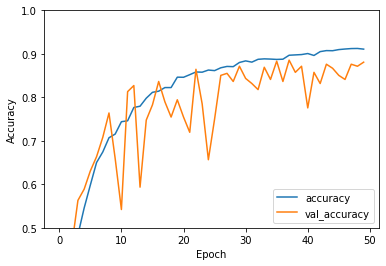

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

In [21]:
# Evaluate the model.

score = model.evaluate(X_test, y_test, verbose=0, batch_size = 32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4703559875488281
Test accuracy: 0.8884210586547852


As we see from the learning graph the model is learning well, but it's **slightly overfitting after the 35th epoch.** Therefore, let's use some techniques to prevent overfitting. 

Validation accuracy is approximately constant after the 25th epoch. **Let's reduce the learning rate when the validation loss does not change. **

## **Additional Content**

### **Preventing Overfitting**

Overfitting is a problem in machine learning in which our model performs very well on the training data but performs poorly on testing data.

**The problem of overfitting is severe in deep learning**, since the neural network automatically detects several features and builds a complex mathematical model with several layers to map the input to the output. The tendency of deep neural networks to overfit to the training dataset could affects our end result badly, so this issue has to be addressed immediately.

There are many **regularization techniques** to overcome overfitting: 

**1) Dropout**

**2) Data Augmentation** 

**3) Batch Normalization** (weak regularizer)

Let's use Data augmentation here to prevent overfitting and make the model more robust for inference.

In this problem, we are using the ImageDataGenerator() function which randomly changes the characteristics of images and provides randomness in the data. To avoid overfitting, we need a function. This function randomly changes the image characteristics. Check the below code on how to reduce overfitting.


**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

### **Data Augmentation (Regularization)**

Data Augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data Augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks in order to help regularize them and reduce overfitting.

Please read about Imagedatagenerator from [here](https://keras.io/api/preprocessing/image/)

In [23]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

**Dividing the training data into train and validation/dev set from X_train**

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.1, random_state=seed,stratify=y_train)

In [25]:
X_train.shape

(3847, 128, 128, 3)

### **Defining the model**

In [26]:
# Set the CNN model 
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (None,128,128, 3)))


model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.2))


model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.4))

model1.add(GlobalMaxPooling2D())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(12, activation = "softmax"))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [27]:
#Defining thr optimizer and loss function 
model1.compile(optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [28]:
#Fitting the model using fit_generator function 
batch_size = 32
history1 = model1.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
120/120 - 15s - loss: 2.3611 - accuracy: 0.1861 - val_loss: 2.1621 - val_accuracy: 0.2453 - lr: 0.0010 - 15s/epoch - 128ms/step
Epoch 2/30
120/120 - 14s - loss: 2.0625 - accuracy: 0.2752 - val_loss: 1.9700 - val_accuracy: 0.3855 - lr: 0.0010 - 14s/epoch - 116ms/step
Epoch 3/30
120/120 - 14s - loss: 1.7840 - accuracy: 0.3727 - val_loss: 1.6127 - val_accuracy: 0.4650 - lr: 0.0010 - 14s/epoch - 116ms/step
Epoch 4/30
120/120 - 14s - loss: 1.5917 - accuracy: 0.4422 - val_loss: 1.5011 - val_accuracy: 0.5000 - lr: 0.0010 - 14s/epoch - 116ms/step
Epoch 5/30
120/120 - 14s - loss: 1.4314 - accuracy: 0.5035 - val_loss: 1.4284 - val_accuracy: 0.5257 - lr: 0.0010 - 14s/epoch - 117ms/step
Epoch 6/30
120/120 - 14s - loss: 1.3363 - accuracy: 0.5360 - val_loss: 1.2144 - val_accuracy: 0.6238 - lr: 0.0010 - 14s/epoch - 116ms/step
Epoch 7/30
120/120 - 14s - loss: 1.2076 - accuracy: 0.5890 - val_loss: 1.1828 - val_accuracy: 0.6005 - lr: 0.0010 - 14s/epoch - 116ms/step
Epoch 8/30
120/120 - 14s - 

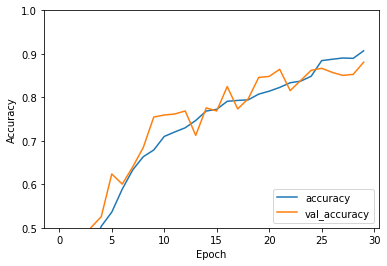

In [29]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

As you can see from the learning graph, **the overfitting has been reduced.** The model is **generalizing well to the validation set.**

In [30]:
# Evaluate the model.

score = model1.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.29168379306793213
Test accuracy: 0.8884210586547852


As you can see, we are getting better inference accuracy here.

### **Plotting the confusion matrix**

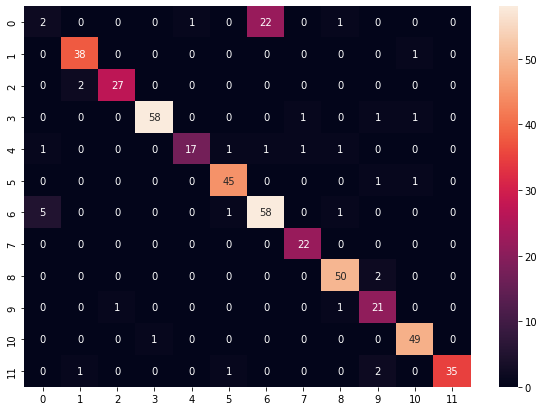

In [31]:
# Predict the values from the validation dataset
Y_pred = model1.predict(X_test)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_true, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 12)],
                  columns = [i for i in range(0, 12)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

### **Visualizing the prediction**

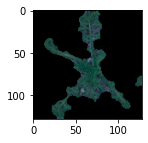

Predicted Label 8
True Label 8


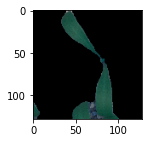

Predicted Label 11
True Label 11


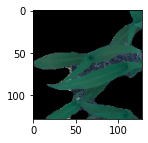

Predicted Label 7
True Label 7


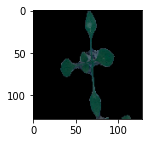

Predicted Label 3
True Label 3


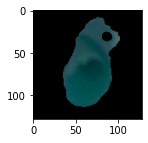

Predicted Label 7
True Label 7


In [32]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[33],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[33].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[33]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[59].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[59]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[36],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[36].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[36]))

### **Conclusion**

**The model accuracy becomes constant after the 25th epoch**, reducing learning rate works well at this time.

**Data Augmentation works as a regularizer** and helps to reduce the variance in the training and increases the generalization of the model.
